<a href="https://colab.research.google.com/github/MaanasSM/Deep-Learning-Mini-Projects/blob/main/AutoEncoders_exp8_26_2_25_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I am going to use Autoencoders for image denoising. Autoencoders have a very special structure, it takes an input and learns to recreate it as the output. This property of Autoencoders gives them a wide functionality  I have used them in one of my notebooks for creating an [ECG anomaly detector](https://www.kaggle.com/devavratatripathy/ecg-anomaly-detection-using-autoencoders)( do check it out !).In this I am going to use them to denoise the images of fashion MNIST dataset. First I will create noisy images from the original images then I will train the autoencoder with the noisy images as input and the original ones as output so that it wil learn how to denoise an image.

I will try to make it as easy to understand as possible

So lets dive in...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
#Lets get the fashion MNIST data
(x_train, _),(x_test, _) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Noice the shape of the train data
#Each image resolution is 28X28
x_train.shape

(60000, 28, 28)

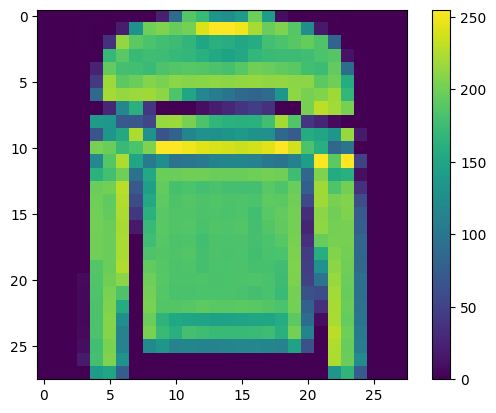

In [ ]:
#Let's see one of the images!
plt.imshow(x_train[5])
plt.colorbar()
plt.show()

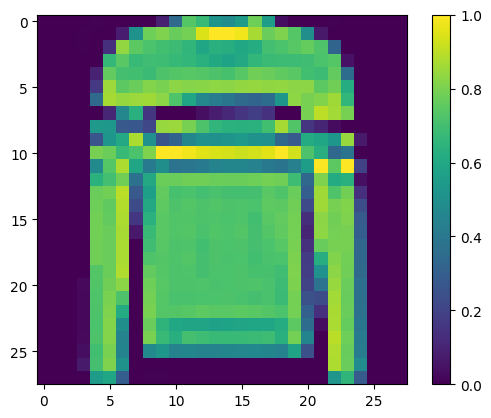

In [ ]:
#As we can see that the pixel values range from 0 to 255 so lets scale them down to 0 to 1
x_train = x_train / 255.0
x_test = x_test / 255.0

#Now lets check...
plt.imshow(x_train[5])
plt.colorbar()
plt.show()

In [ ]:
#Lets reshape the data for feeding into the model (which is to be made)
#Since this will be passed into the CNN I will use the reshape() function to add a new dimension
#As u can see in the output that the only change is that we have got a new dimesion of value 1
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_train.shape

(60000, 28, 28, 1)

**Now lets create noise in the images...**

By noise we mean random disturbances in the image , so this can be done by adding some randomly generated value to each pixel value of our images.
For this purpose we use the **tf.random.normal()** function which generates a tensor of the given shape with randomly generated values from a normalised ditribution.
We multiply the random values by a **noise factor** which you can decide according to your needs, it just controls the extent to which the pixel values will be modeified (e.g if the random no generated is 0.5 and the original pixel value is 0.6 , then a noise factor of 0.2 will give us the pixel value as 0.7 but a noise factor of 0.3 will give us 0.75).

After generating random noise the images are no longer scaled to the limit 0 to 1 because the randomly generated numbers can be -ve (since they are from normal distribution). So to rescale the values to the range 0 to 1  I have used the **tf.clip_by_value()** which clips the values that lie outside the threshold(min and max) and reduces them to the threshold values(which here are 0 and 1).

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape = x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape = x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0, clip_value_max = 1)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0, clip_value_max = 1)

**Note** that here if we just directly use plt.imshow() then it will throw an error. The reason beng that we added an extra dimesion 1 to our dataset but imshow() expects an 2-D array , so we need to somehow get rid of that extra dimesion and here **tf.squeeze()** comes in handy. This function removes the dimensions with value 1.
For example if the shape of the tensor is (5, 4, 2, 1) then this function will output a tensor with shape (5, 4, 2).
Check the tensorflow documentation for a better understanding.

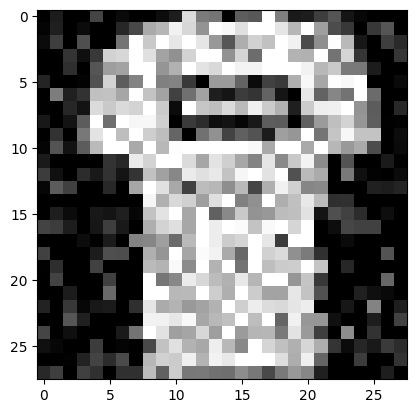

In [ ]:
tf.shape(tf.squeeze(x_train_noisy[0]))
#lets see the noisy images
plt.imshow(tf.squeeze(x_train_noisy[1]))
plt.gray()

Now let's create our model !

As I mentioned earlier we are going to use Autoencoder for this model. Autoencoder is a special type of neural network that is trined to reconstruct its input as output. Its network architecture is slightly different as it consists of 2 parts :- 1) encoder- compresses and encodes the input , 2)decoder- reconstructs the input from the encoded data. I have explained autoencoders briefly in my other notebook regarding [ECG Anomaly detection using autoencoders](https://www.kaggle.com/devavratatripathy/ecg-anomaly-detection-using-autoencoders)Here i have impemented it and also provided links to some other articles abut autoencoders. So do check it out !




Coming to our model, first it has an **encoder** which has convolutional layers that compress the original image. Its a fairly simple CNN. The imporatant part is in the **decoder** as here u can notice that instead of the usual Conv2D layers I have used **Conv2DTranspose**. This layer is for **upsampling** the compressed image.
So lets understand what does it does...
The job of the decoder is to reconstruct the output from the compressed input and as we know that a convolution operation on an image reduces the dimension of the image while increasing the channels depending on the no. of filters. This action compresses the input image and in order to reconstruct it we need to kindof need to decompress it. So u can think that the Conv2DTranspose performs some sort of deconvolution type of operation( although in reality its way more complex so for intuition we can think of it as deconvolution) which increases the image size and resolution. Just think of it as upscaling the image.
There are some other upsampling methods but they perform poorly as compared to this and we can also use the regular Conv2D but it also kind of performs less effectively.
Note that in the end I have  also used a regular convolutional layer to bring the image back to its original dimensions of (28x28X1)


In [ ]:
class autoencoder(Model):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape = (28, 28,1)),
            layers.Conv2D(18, (3,3), activation = 'relu', padding = 'same', strides = 2),
            layers.Conv2D(9, (3,3), activation = 'relu', padding = 'same', strides = 2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(9, (3,3), activation = 'relu', padding = 'same', strides = 2),
            layers.Conv2DTranspose(18, (3,3), activation = 'relu', padding = 'same', strides = 2),
            layers.Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same', strides = 1)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
#Lets compile the model...
Autoencoder = autoencoder()
Autoencoder.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
history = Autoencoder.fit(x_train_noisy, x_train,
               epochs = 5,
               shuffle = True,
               validation_data = (x_test_noisy, x_test)
               )

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0312 - val_loss: 0.0095
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0089 - val_loss: 0.0080
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0070 - val_loss: 0.0068


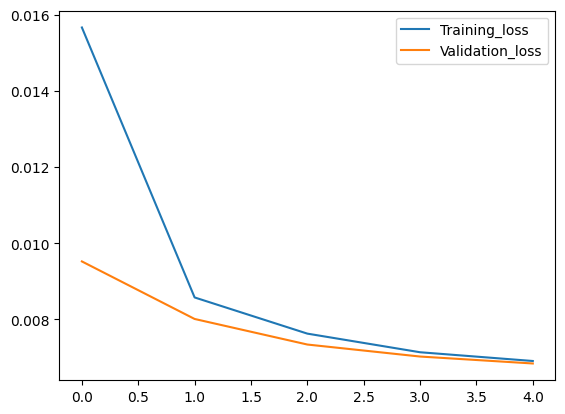

In [ ]:
#Now lets plot the losses
plt.plot(history.history['loss'], label = 'Training_loss')
plt.plot(history.history['val_loss'], label = 'Validation_loss')
plt.legend()
plt.show()

In [ ]:
#Now lets test our model with test data
#We input the test data into the encoder and get the encoded images
encoded_images = Autoencoder.encoder(x_test_noisy).numpy()

#Then we input the encoded images into the decoder and get the decoded and denoised images
decoded_images = Autoencoder.decoder(encoded_images).numpy()

In [ ]:
decoded_images.shape

(10000, 28, 28, 1)

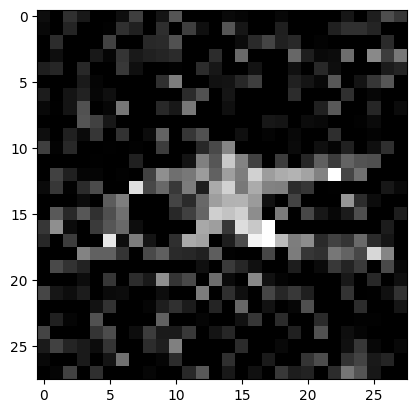

In [ ]:
#Lets see the noisy input image ...
plt.imshow(tf.squeeze(x_test_noisy[52]))
plt.gray()

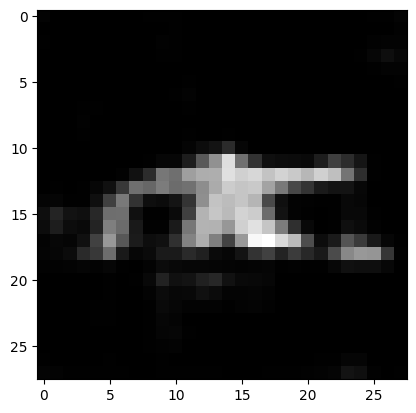

In [ ]:
#Now the denoised image
plt.imshow(tf.squeeze(decoded_images[52]))
plt.gray()

This was a basic model you can improve it by tuning the  hyperparameters and making the CNN more dense with pooling and normalization ,etc.This approach can be used for preprocesing images before feeding them into some other model as it will improve the data quality.

**UPVOTE IF YOU LIKED THE KERNEL. THANK YOU ....**

Do check out my other notebook on [ECG anomaly detection using autoencoders ](https://www.kaggle.com/devavratatripathy/ecg-anomaly-detection-using-autoencoders)
